In [1]:
import matplotlib
import pandas as pd
import numpy as np
import pickle
import urllib.request
import dateutil.parser
import dateutil.rrule
import dateutil.tz
import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import math

matplotlib.rcParams.update({
    'font.size': 13,
    'timezone': 'Europe/London',
    'figure.max_open_warning': False
})

# Traffic volumes across Tyne and Wear

The below charts show the last four weeks of daily traffic profiles across the whole of Tyne and Wear. This is based on plate reads by the region's ANPR network, and is normalised against the normal peak daily vehicle flows (i.e. 100% is normal worst part of rush hour traffic).

In [2]:
tzUTC = dateutil.tz.gettz('UTC')
tzLocal = dateutil.tz.gettz('Europe/London')
govChartStart = datetime.datetime.strptime('2020-03-01T00:00:00Z', '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=tzLocal)
pdTrafficTyneWear = pickle.load(open('../cache/recent-traffic-volumes-pd.pkl', 'rb'))

resampleInterval = 60 * 8 # N minute data

timezoneOffset = ((60 - np.min(pdTrafficTyneWear.index).time().minute) * 60) if np.min(pdTrafficTyneWear.index).time().minute > 0 else 0
#print('Has %u second offset in resampling' % timezoneOffset)

In [3]:
# This should really be factoring in the number of observations too, as a per-camera count
pdTrafficAllSum = pdTrafficTyneWear.resample('%us' % resampleInterval, closed='right', label='right').sum().sum(axis=1).to_frame().rename(columns={0: 'Total'})
#pdTrafficAllSum.plot(figsize=(18, 8))
#pdTrafficAllSum

In [4]:
#pdTrafficAllSum.plot(figsize=(18, 8))

In [5]:
dateToday = datetime.datetime.combine(datetime.date.today(), datetime.datetime.min.time()).replace(tzinfo=tzLocal)
lastWeekStart = dateToday - pd.Timedelta(days=6)
lastWeekEnd = dateToday + pd.Timedelta(hours=24)
#print(dateToday)
#print(lastWeekStart)
#print(lastWeekEnd)

In [6]:
pdTrafficPreCV = pdTrafficAllSum[pdTrafficAllSum.index < govChartStart]
pdTrafficPostCV = pdTrafficAllSum[(pdTrafficAllSum.index >= govChartStart) & (pdTrafficAllSum.index < np.max(pdTrafficAllSum.index) - pd.Timedelta(seconds=resampleInterval))]
#pdTrafficPostCV

In [7]:
pdTrafficPreCV.insert(0, 'Day of week', pdTrafficPreCV.index.to_series().apply(lambda t: t.strftime('%A')))
pdTrafficPreCV.insert(0, 'Time of day', pdTrafficPreCV.index.to_series().apply(lambda t: (t if bool(t.dst()) == False else (t - pd.Timedelta(seconds=timezoneOffset))).strftime('%H:%M:%S')))
pdTrafficPreCVAverage = pdTrafficPreCV \
    .groupby(['Day of week', 'Time of day'], as_index=False) \
    .median()
pdTrafficPreCVLowerQuantile = pdTrafficPreCV \
    .groupby(['Day of week', 'Time of day'], as_index=False) \
    .quantile(0.10)
pdTrafficPreCVUpperQuantile = pdTrafficPreCV \
    .groupby(['Day of week', 'Time of day'], as_index=False) \
    .quantile(0.90)

pdTrafficPostCV.insert(0, 'Day of week', pdTrafficPostCV.index.to_series().apply(lambda t: t.strftime('%A')))
pdTrafficPostCV.insert(0, 'Time of day', pdTrafficPostCV.index.to_series().apply(lambda t: (t if bool(t.dst()) == False else (t - pd.Timedelta(seconds=timezoneOffset))).strftime('%H:%M:%S')))

In [8]:
#pdTrafficPreCV

In [9]:
# Give the proper order to the days in the last week
weekDaysOrder = list(map(lambda daysAgo: (dateToday - pd.Timedelta(days=6) + pd.Timedelta(days=daysAgo)).strftime('%A'), list(range(0, 7))))
pdTrafficPreCVAverage.insert(0, 'Days into last week', pdTrafficPreCVAverage['Day of week'].apply(lambda day: weekDaysOrder.index(day)))
pdTrafficPreCVLowerQuantile.insert(0, 'Days into last week', pdTrafficPreCVAverage['Day of week'].apply(lambda day: weekDaysOrder.index(day)))
pdTrafficPreCVUpperQuantile.insert(0, 'Days into last week', pdTrafficPreCVAverage['Day of week'].apply(lambda day: weekDaysOrder.index(day)))

In [10]:
pdTrafficPreCVAverage.sort_values(['Days into last week', 'Time of day'], inplace=True)
pdTrafficPreCVLowerQuantile.sort_values(['Days into last week', 'Time of day'], inplace=True)
pdTrafficPreCVUpperQuantile.sort_values(['Days into last week', 'Time of day'], inplace=True)
pdTrafficPreCVAverage = pdTrafficPreCVAverage.reset_index(drop=True)
pdTrafficPreCVLowerQuantile = pdTrafficPreCVLowerQuantile.reset_index(drop=True)
pdTrafficPreCVUpperQuantile = pdTrafficPreCVUpperQuantile.reset_index(drop=True)
#pdTrafficPreCVAverage

In [11]:
pdTrafficPreCVAverage.index = pdTrafficPreCVAverage.index.to_series().apply(
  lambda rowId: lastWeekStart + pd.Timedelta(seconds=rowId * resampleInterval)
)
pdTrafficPreCVLowerQuantile.index = pdTrafficPreCVLowerQuantile.index.to_series().apply(
  lambda rowId: lastWeekStart + pd.Timedelta(seconds=rowId * resampleInterval)
)
pdTrafficPreCVUpperQuantile.index = pdTrafficPreCVUpperQuantile.index.to_series().apply(
  lambda rowId: lastWeekStart + pd.Timedelta(seconds=rowId * resampleInterval)
)

#pdTrafficPreCVUpperQuantile

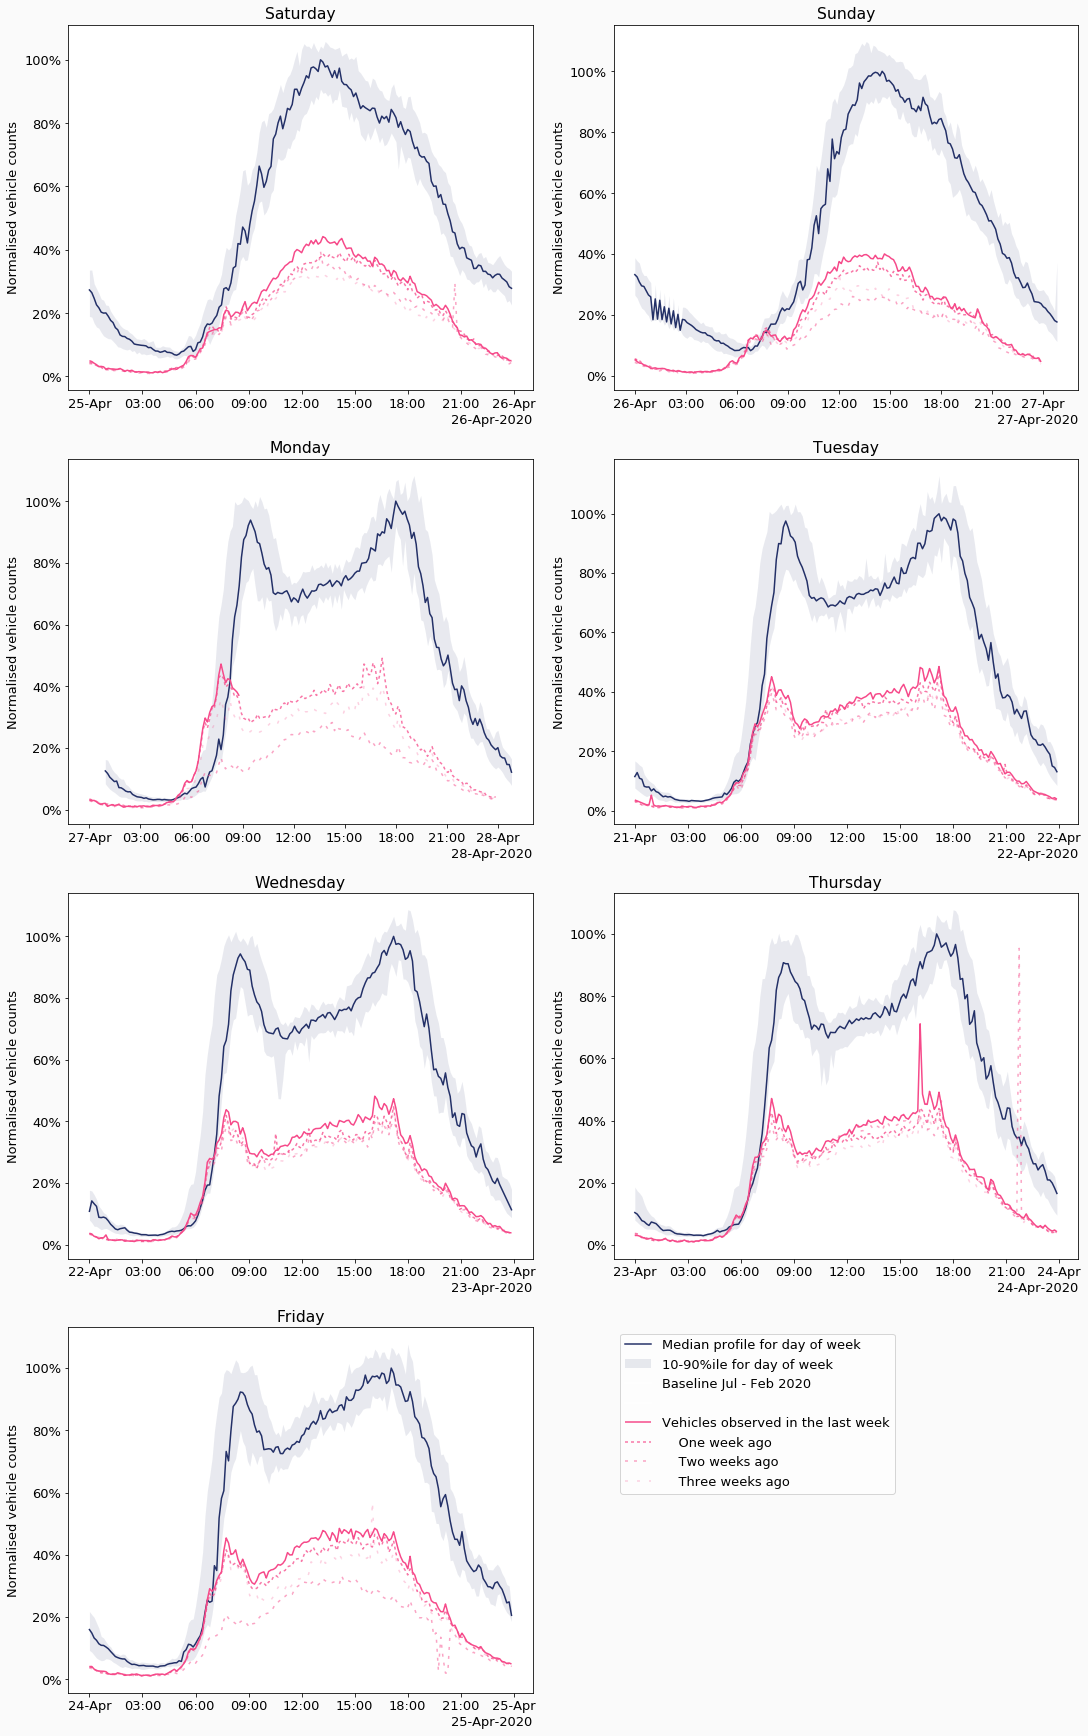

In [12]:
# For Twitter sharing... transparency doesn't work so well when some browsers default to black background
%config InlineBackend.print_figure_kwargs={'facecolor' : '#fafafa'}

fig, axs = plt.subplots(
    4, 2,
    figsize = (15, 6 * 4),
    constrained_layout=True
)

for idx, dayOfWeek in enumerate(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']):
    #dayOfWeek = 'Saturday'
    
    ax = axs[math.floor(idx / 2), idx % 2]
    
    # Normalise the data against the normal maximum for this day of the week...
    normalisedVolume = pdTrafficPreCVAverage[pdTrafficPreCVLowerQuantile['Day of week'] == dayOfWeek]['Total'].max(axis=0)

    medianPlot = ax.plot(pdTrafficPreCVAverage[pdTrafficPreCVAverage['Day of week'] == dayOfWeek]['Total'] / normalisedVolume, label='%s average (Jul 2019 -)' % dayOfWeek, color='#233067')
    percentileLegend = ax.fill_between(
        pdTrafficPreCVLowerQuantile[pdTrafficPreCVLowerQuantile['Day of week'] == dayOfWeek]['Total'].index,
        pdTrafficPreCVLowerQuantile[pdTrafficPreCVLowerQuantile['Day of week'] == dayOfWeek]['Total'] / normalisedVolume,
        pdTrafficPreCVUpperQuantile[pdTrafficPreCVLowerQuantile['Day of week'] == dayOfWeek]['Total'] / normalisedVolume,
        color='#233067',
        linewidth=0,
        alpha=0.1,
        label='15-85%%ile for %s' % dayOfWeek
    )

    plotWeeks = 4
    plotAlpha = 1.0
    plotLegends = []

    for weeksAgo in range(0, plotWeeks):
        postCVSingleWeek = pdTrafficPostCV[
            (pdTrafficPostCV.index >= lastWeekStart - pd.Timedelta(days = 7 * weeksAgo)) &
            (pdTrafficPostCV.index < lastWeekEnd - pd.Timedelta(days = 7 * weeksAgo))
        ].shift(
            periods=7 * weeksAgo,
            freq='d'
        )
        plotLegends.append(ax.plot(
            postCVSingleWeek[postCVSingleWeek['Day of week'] == dayOfWeek]['Total'] / normalisedVolume,
            label=None if plotAlpha < 1.0 else '%s for last %u weeks' % (dayOfWeek, plotWeeks),
            linestyle='solid' if plotAlpha == 1.0 else '--',
            dashes=(2, weeksAgo * 2),
            color='#f64a8a',
            alpha=plotAlpha
        )[0])
        plotAlpha = plotAlpha - 0.25


    timeLocatorMajor = mdates.AutoDateLocator(minticks=6, maxticks=10)
    conciseZeroFormats = ['', '%Y', '%b', '%d-%b', '%H:%M', '%H:%M']
    conciseOffsetFormats = ['', '%Y', '%b-%Y', '%d-%b-%Y', '%d-%b-%Y', '%d-%b-%Y %H:%M']
    ax.xaxis.set_tick_params(which='major')
    ax.xaxis.set_major_locator(timeLocatorMajor)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator=timeLocatorMajor, zero_formats=conciseZeroFormats, offset_formats=conciseOffsetFormats, tz=tzLocal))
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_facecolor('white')
    ax.set_clip_on(False)

    ax.set_title(dayOfWeek)
    ax.set_ylabel('Normalised vehicle counts')

# Hide the final plot...
ax = axs[3][1]
ax.axis('off')

ax.legend(
    [
        medianPlot[0],
        percentileLegend,
        plt.Line2D([0],[0],color="w"),
        plt.Line2D([0],[0],color="w")
    ] + plotLegends,
    [
        'Median profile for day of week',
        '10-90%ile for day of week',
        'Baseline Jul - Feb 2020',
        ''
    ] + [
        'Vehicles observed in the last week',
        '    One week ago',
        '    Two weeks ago',
        '    Three weeks ago'
    ],
    loc='upper left',
    ncol=1
)
    
# plt.legend(ncol=1, loc='upper left', fontsize=10)
# plt.tight_layout()
plt.show()